In [1]:
import os

# 数据路径配置
train_data_path = "../data/riddles/zimi/zimi_train_data.csv"
model_save_path = "../models/keyword_extractor"

# 模型和Tokenizer路径
pretrained_model_name = "fnlp/bart-base-chinese"

# 超参数配置
max_length = 50
batch_size = 16
learning_rate = 5e-5
num_epochs = 5
test_size = 0.2

# 检查并创建保存模型的目录
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)


In [2]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BartForConditionalGeneration, Text2TextGenerationPipeline
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score

2024-06-09 03:35:00.770598: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 03:35:01.001475: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 03:35:01.001577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 03:35:01.043600: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-09 03:35:01.140209: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 03:35:01.142599: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
# 安全地将字符串转换为原始格式（列表或字典），对于无效格式返回原始值。
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val) if not pd.isna(val) else val
    except (ValueError, SyntaxError):
        return val

# 读取数据
zimi_df = pd.read_csv(train_data_path).dropna()
zimi_df['拆字'] = zimi_df['拆字'].apply(safe_literal_eval)
zimi_df['pronunciation_details'] = zimi_df['pronunciation_details'].apply(safe_literal_eval)
zimi_df.head(5)


,字符,笔画数,拼音,偏旁部首,频率,结构代码,拆字,结构方式,间架比例,char,index,pinyin,pronunciation_details,结构谜底,拆字谜底,谜底,字谜
0,当,6,dàng,彐,0,B0,[小 彐],上下结构,上下结构,当,418.0,dàng,"{'pinyin': 'dàng', 'explanations': [{'content'...",[上下],小彐,[上下]小彐,天空翱翔小，大地奔腾彐
1,泛,7,fàn,氵,1,H2,"[水 乏, 氵 乏]",左右结构,左窄右宽,泛,865.0,fàn,"{'pinyin': 'fàn', 'explanations': [{'content':...",[左右],水乏,[左右]水乏,梦想左眼水，现实右眼乏
2,所,8,suǒ,户,0,H1,"[戶 斤, 户 斤, 戸 斤]",左右结构,左右相等,所,1164.0,suǒ,"{'pinyin': 'suǒ', 'explanations': [{'content':...",[左右],戶斤,[左右]戶斤,左部分戶，右部分斤
3,孩,9,hái,子,1,H0,[子 亥],左右结构,左右结构,孩,1730.0,hái,"{'pinyin': 'hái', 'explanations': [{'content':...",[左右],子亥,[左右]子亥,左子右亥，互为表里
4,仇,4,qiú,亻,1,H2,"[人 九, 亻 九]",左右结构,左窄右宽,仇,133.0,qiú,"{'pinyin': 'qiú', 'explanations': [{'content':...",[左右],人九,[左右]人九,梦想左眼人，现实右眼九


In [4]:
data = zimi_df.copy()

inputs = data["字谜"].apply(lambda x: f"请抽取字谜中的关键字：{x}。字谜中的关键字是：")
outputs = data["拆字谜底"].apply(lambda x: f"{x}")

sft_dataset = pd.DataFrame({"input": inputs, "output": outputs})
sft_dataset.head()

,input,output
0,请抽取字谜中的关键字：天空翱翔小，大地奔腾彐。字谜中的关键字是：,小彐
1,请抽取字谜中的关键字：梦想左眼水，现实右眼乏。字谜中的关键字是：,水乏
2,请抽取字谜中的关键字：左部分戶，右部分斤。字谜中的关键字是：,戶斤
3,请抽取字谜中的关键字：左子右亥，互为表里。字谜中的关键字是：,子亥
4,请抽取字谜中的关键字：梦想左眼人，现实右眼九。字谜中的关键字是：,人九


In [5]:
class KeywordDataset(Dataset):
    def __init__(self, tokenizer, input_texts, target_texts, max_length):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.max_length = max_length
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        input_text = self.input_texts[idx]
        target_text = self.target_texts[idx]

        input_encoding = self.tokenizer(input_text, padding='max_length', truncation=True, max_length=self.max_length, return_token_type_ids=False)
        target_encoding = self.tokenizer(target_text, padding='max_length', truncation=True, max_length=self.max_length, return_token_type_ids=False)

        inputs = {key: torch.tensor(val) for key, val in input_encoding.items()}
        targets = {key: torch.tensor(val) for key, val in target_encoding.items()}

        return inputs, targets


In [6]:
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)
model = BartForConditionalGeneration.from_pretrained(pretrained_model_name).to('cuda')

In [7]:
# 创建数据集和数据加载器
data = sft_dataset.copy()
dataset = KeywordDataset(tokenizer, list(data['input']), list(data['output']), max_length=max_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [8]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label='Training Loss', color='blue', linestyle='-', linewidth=2, marker='o')
    plt.plot(val_losses, label='Validation Loss', color='red', linestyle='--', linewidth=2, marker='x')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_accuracies(val_accuracies):
    plt.figure(figsize=(6, 4))
    plt.plot(val_accuracies, label='Validation Accuracy', color='green', linestyle='-', linewidth=2, marker='s')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def evaluate(model, val_loader, tokenizer):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            inputs = {k: v.to(model.device) for k, v in inputs.items()}
            targets = {k: v.to(model.device) for k, v in targets.items()}

            if 'token_type_ids' in inputs:
                del inputs['token_type_ids']

            outputs = model(**inputs, labels=targets['input_ids'])
            total_loss += outputs.loss.item()

            predictions = outputs.logits.argmax(dim=-1)

            for pred, target in zip(predictions, targets['input_ids']):
                pred_text = tokenizer.decode(pred, skip_special_tokens=True)
                target_text = tokenizer.decode(target, skip_special_tokens=True)
                all_predictions.append(pred_text)
                all_targets.append(target_text)

    avg_loss = total_loss / len(val_loader)
    val_accuracy = accuracy_score(all_targets, all_predictions)

    return avg_loss, val_accuracy

def train(model, dataloader, val_loader, model_path, tokenizer):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        total_loss = 0
        loop = tqdm(dataloader, leave=True)
        for batch in loop:
            inputs, targets = batch
            inputs = {k: v.to(model.device) for k, v in inputs.items()}
            targets = {k: v.to(model.device) for k, v in targets.items()}
            
            if 'token_type_ids' in inputs:
                del inputs['token_type_ids']
            
            outputs = model(**inputs, labels=targets['input_ids'])
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_description(f'Epoch {epoch}')
            loop.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(dataloader)
        val_loss, val_accuracy = evaluate(model, val_loader, tokenizer)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}%')

    plot_losses(train_losses, val_losses)
    plot_accuracies(val_accuracies)

    model.save_pretrained(model_path)
    tokenizer.save_pretrained(model_path)


Epoch 0: 100%|██████████| 52/52 [00:10<00:00,  5.04it/s, loss=0.0633]


Epoch 0, Training Loss: 1.5028925040880075, Validation Loss: 0.046937136266093984, Validation Accuracy: 0.5776699029126213%


Epoch 1: 100%|██████████| 52/52 [00:10<00:00,  4.96it/s, loss=0.0241]  


Epoch 1, Training Loss: 0.022496950958156958, Validation Loss: 0.009296817293104071, Validation Accuracy: 0.912621359223301%


Epoch 2: 100%|██████████| 52/52 [00:10<00:00,  4.95it/s, loss=0.000446]


Epoch 2, Training Loss: 0.0066658568371517155, Validation Loss: 0.00479249123376436, Validation Accuracy: 0.970873786407767%


Epoch 3: 100%|██████████| 52/52 [00:10<00:00,  4.92it/s, loss=0.000388]


Epoch 3, Training Loss: 0.0027801483598663113, Validation Loss: 0.00327290441446866, Validation Accuracy: 0.9757281553398058%


Epoch 4: 100%|██████████| 52/52 [00:10<00:00,  4.89it/s, loss=0.000808]


Epoch 4, Training Loss: 0.0013145183877965722, Validation Loss: 0.002669172435372065, Validation Accuracy: 0.9854368932038835%


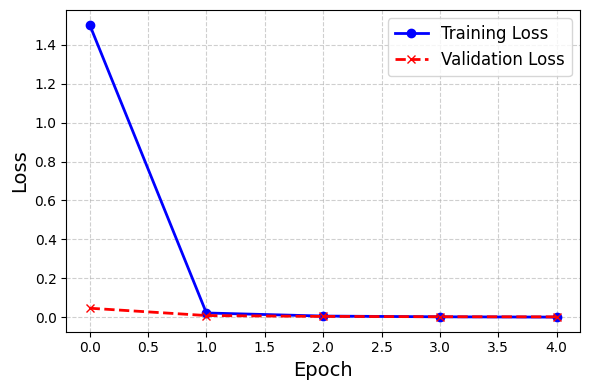

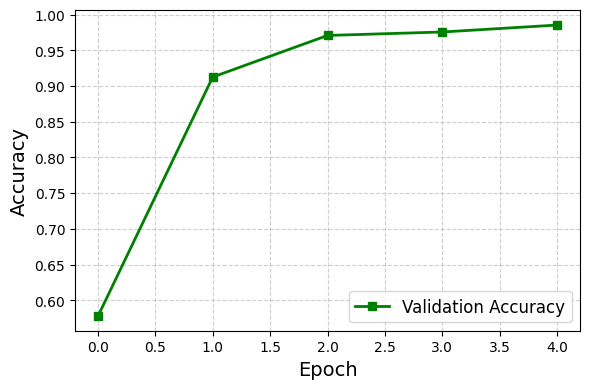

In [9]:
# 分割数据为训练集和验证集
train_data, val_data = train_test_split(data, test_size=test_size, random_state=42)

# 创建训练集的DataLoader
train_dataset = KeywordDataset(tokenizer, list(train_data['input']), list(train_data['output']), max_length=max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 创建验证集的DataLoader
val_dataset = KeywordDataset(tokenizer, list(val_data['input']), list(val_data['output']), max_length=max_length)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 开始训练并保存模型
train(model, train_loader, val_loader, model_save_path, tokenizer)


In [10]:
text2text_generator = Text2TextGenerationPipeline(model.to('cpu'), tokenizer)
example = "请抽取字谜中的关键字：左边是人，右边是乙。字谜中的关键字是：[MASK]"
output = text2text_generator(example, max_length=max_length, do_sample=False)
print(output)


[{'generated_text': '人 乙'}]
